# The  Research  Space

"Here we use a large dataset of scholarly publications disambiguated at the individual level to create a map of science — or research  space — where links connect pairs of fields based on the probability that an individual has published in both of them."
[Original Article](https://arxiv.org/ftp/arxiv/papers/1602/1602.08409.pdf)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import networkx as nx
import pandas as pd
import numpy as np
import re

In [2]:
plt.rcParams["figure.figsize"] = (15,10)

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Our data

PRECISO CHECAR O PARSER NOVAMENTE. ALGUNS ANOS APARECERAM COMO 'rint' OU 'onic'. E EM ALGUNS ARTIGOS O NÚMERO DE AUTORES FOI ZERO.

Todas as publicações

In [4]:
articles = pd.read_csv("../dataset/lattes_categories.csv", sep=";sep;", engine="python")
articles = articles[(articles["ano"] != 'rint') & (articles["ano"] != 'onic')]
articles.head()

,pesq,ano,catg,num
0,99900328713566,2007,"Plant Science (Q2); Ecology, Evolution, Behavi...",3.0
1,99900328713566,2007,"Plant Science (Q2); Ecology, Evolution, Behavi...",4.0
2,99900328713566,2007,Plant Science (Q2),3.0
3,99900328713566,2009,Plant Science (Q2),2.0
4,99900328713566,2009,Plant Science (Q2),2.0


Macro subjects

In [5]:
areas = pd.read_csv("../dataset/SJR/areas.txt", sep=";")
areas["Field"] = areas["Field"].apply(lambda x: x.strip().lower())
areas.head()

,Code,Field,Subject area
0,1000,multidisciplinary,Health Sciences
1,1100,general agricultural and biological sciences,Life Sciences
2,1101,agricultural and biological sciences (miscella...,Life Sciences
3,1102,agronomy and crop science,Life Sciences
4,1103,animal science and zoology,Life Sciences


Instituição do pesquisador, caso queiramos agregar os dados

In [6]:
bio = pd.read_csv("../dataset/lattes/pesquisadores.csv", sep=";sep;", engine="python")
bio.head()

,id_pesquisador,nome_instituicao,cep_instituicao
0,0099900328713566,Universidade Federal do Oeste da Bahia,47808021
1,0026846500140475,"Instituto Federal de Educação, Ciência e Tecno...",49032490
2,0084190106475603,Universidade Federal do Rio de Janeiro,21945-970
3,0027688823067577,"Instituto Federal de Educação, Ciência e Tecno...",45320000
4,0017466571949740,Ministério Público do Estado do Rio de Janeiro,20020080


### Filtering

"We filter this dataset by focusing only on scholars with less than fifty publications in each year, because those with more than fifty publications tend to have many publications that are miss-assigned and are not theirs"

VOU IGNORAR PORQUE NO LATTES É O USUÁRIO QUEM COLOCA.

### Matrix

" $\phi_{ff'}(T)$ is  the  adjacency  matrix  representing  the  research  space expressed  by  the  career trajectory of scientists in our dataset observed up to time T. "

Get all the categories from an article

In [7]:
def catg(s):
    return [re.sub(r"\s?\(Q[1-9]\)", "", x).strip().lower() for x in s.split(";")]

POR QUE TEM ARTIGOS COM ZERO AUTORES??

Create a dict to represent the X matrix

In [8]:
def X(t):
    x = dict()
    for _, row in articles.iterrows():
        if int(row["ano"]) < t:
            fs = catg(row["catg"])
            nf = len(fs)
            for field in fs:
                
                if row["num"] == 0:
                    continue
                
                if (row["pesq"], field) in x:
                    x[(row["pesq"], field)] += 1/(nf * row["num"])
                else:
                    x[(row["pesq"], field)] = 1/(nf * row["num"])
    
    print("X done")
    return x

Create a dict to represent the P matrix

In [9]:
def P(t):
    x = X(t)
    p = dict()
    
    for sf in x:
        if x[sf] > 0.1:
            p[sf] = 1
            
    print("P done")
    return p

Create the M matrix

In [10]:
def M(t):
    p = P(t)
    s = set()
    f = set()
    
    for sf in p:
        s.add(sf[0])
        f.add(sf[1])
        
    of = sorted(list(f))
    indices = {u: v for v, u in enumerate(of)}
    n = len(of)
    m = np.zeros((n,n))
    
    for i in range(len(of)):
        for j in range(i+1, len(of)):
            for k in s:
                if (k,of[i]) in p and (k,of[j]) in p:
                    m[i,j] += 1
                    m[j,i] += 1
                    
    print("M done")
    return [m, p, of]

Create the phi matrix

In [11]:
def phi(t):
    m, p, of = M(t)
    indices = dict()
    sums = np.zeros(len(m))
    
    for sf in p:
        if sf[1] not in indices:
            indices[sf[1]] = of.index(sf[1])
        sums[indices[sf[1]]] += 1

    phi = m.copy()
    for i in range(len(m)):
        phi[:,i] /= sums[i]
    
    print("phi done")
    return [phi, of]

Salvar só pra ter certeza né. As etapas do X e do M são bastante demoradas.

In [ ]:
k, of = phi(2011)
np.save("../dataset/phi_matrix_2011.npy", k)

with open("../dataset/of_2011.txt", "w") as f:
    for item in of:
        f.write("{}\n".format(item))

In [12]:
k = np.load("../dataset/phi_matrix_2011.npy")

of = list()
with open("../dataset/of_2011.txt", "r") as f:
    for item in f:
        of.append(item.strip())

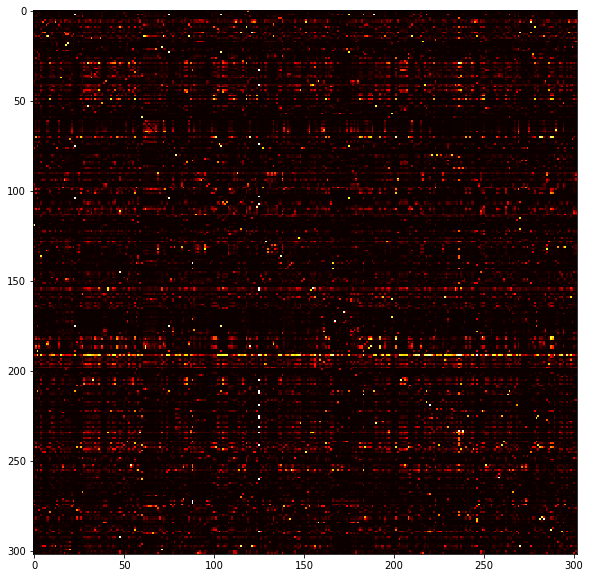

In [13]:
plt.imshow(k, cmap='hot', interpolation='nearest')
plt.show()

### Graph Plot

Get colors

In [14]:
def get_colors(area, subs):
    values = [subs[area[node]] for node in of]

    cm = plt.get_cmap('Set2')
    cNorm = colors.Normalize(vmin=0, vmax=max(values))
    scalar_map = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
    return [cm, scalar_map, values]

Get node size

In [15]:
def get_node_size():
    values = [40 for node in of]
    values[of.index("computer science applications")] = 300    
    return values

Plot function

In [16]:
def show_graph(A, area, subs, pos=None, threshold=0.212):
    G = nx.from_numpy_matrix(A)
    mast = nx.maximum_spanning_tree(G)
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i != j:
                if A[i,j] > threshold:
                    mast.add_edge(i,j)
        
    if pos == None:
        pos = nx.spring_layout(mast)
    
    cm, scalarMap, values = get_colors(area, subs)
    
    f = plt.figure(1)
    ax = f.add_subplot(1,1,1)
    for label in subs:
        ax.plot([0],[0], color = scalarMap.to_rgba(subs[label]), label = label, lw=7)
        
    nx.draw_networkx(mast, pos, cmap=cm, vmin=0, vmax= max(values), node_color=values, with_labels=False,
                     ax=ax, node_size=get_node_size(), edge_size=1, edge_color="lightgray")
                                                                                                            
    plt.axis('off')
    f.set_facecolor('w')
    plt.legend(loc='upper left')
    plt.show()
    
    return pos

Using macro subjects

Vemos que "computer science applications" é uma área de interação entre ciências da natureza e sociais.

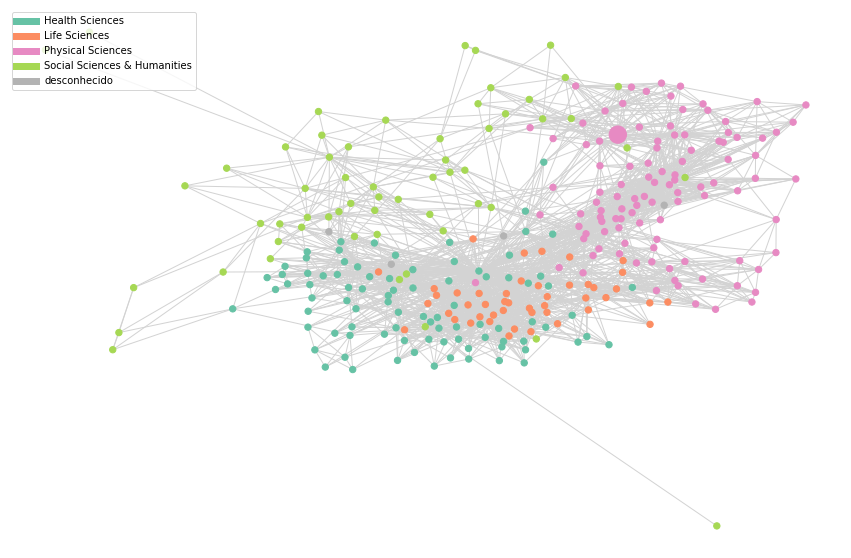

In [20]:
dict_area = areas[["Field", "Subject area"]].set_index("Field").to_dict()["Subject area"]
for u in ["e-learning", 'nanoscience and nanotechnology', 'social work', 'sports science']:
    dict_area[u] = "desconhecido"

unique = areas["Subject area"].unique()
subs = {u: v for v,u in enumerate(sorted(unique))}
subs["desconhecido"] = 5

pos = show_graph(k, dict_area, subs)

Podemos variar o valor do threshold para melhor visualizar

In [21]:
def f(th):
    show_graph(k, dict_area, subs, pos, th)

interact(f, th=(0.05,0.95,0.05))

interactive(children=(FloatSlider(value=0.45, description='th', max=0.95, min=0.05, step=0.05), Output()), _do…

<function __main__.f(th)>

In [22]:
of

['accounting',
 'acoustics and ultrasonics',
 'advanced and specialized nursing',
 'aerospace engineering',
 'aging',
 'agricultural and biological sciences (miscellaneous)',
 'agronomy and crop science',
 'algebra and number theory',
 'analysis',
 'analytical chemistry',
 'anatomy',
 'anesthesiology and pain medicine',
 'animal science and zoology',
 'anthropology',
 'applied mathematics',
 'applied microbiology and biotechnology',
 'applied psychology',
 'aquatic science',
 'archeology',
 'archeology (arts and humanities)',
 'architecture',
 'artificial intelligence',
 'arts and humanities (miscellaneous)',
 'assessment and diagnosis',
 'astronomy and astrophysics',
 'atmospheric science',
 'atomic and molecular physics, and optics',
 'automotive engineering',
 'behavioral neuroscience',
 'biochemistry',
 'biochemistry (medical)',
 'biochemistry, genetics and molecular biology (miscellaneous)',
 'bioengineering',
 'biological psychiatry',
 'biomaterials',
 'biomedical engineering',
 